Strategy of this notebook:
1. EDA to find outliner and remove them

2. Construct dataframe, mean encoding and add time lag. Through LB probing, time lag of 6 months is enough

3. Gridsearch CV for xgboost. It turns out Xgboost is the best (0.934277) 

4. Catboost (1.070510)

5. Stacking (1.191728): train xgboost and linear regression on < 32, predict 33 and 34. Train LogisticRegression on 33 and stack on 34

In [1]:
#### import library
#### define functions


#Submit an all 0 submission, the score is 1.250111 in public and 1.236582 in private.
# Not bad.


## library versions

"""
numpy 1.17.4
pandas 0.25.3
sklearn 0.21.3
tqdm 4.39.0
xgboost 0.90
seaborn 0.9.0
matplotlib 3.1.1
catboost 0.20

"""


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
from sklearn.metrics import r2_score
from sklearn.model_selection import GroupKFold
#import itertools
from itertools import product
import gc
import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from math import sqrt

import xgboost
import xgboost as xgb

import catboost
from catboost import CatBoostRegressor

import os

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

for p in [np, pd, sklearn, tqdm, xgboost, sns, matplotlib, catboost]:
    print (p.__name__, p.__version__)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    

    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

####tmp2 = target_encoding(tmp, ["shop_id"], "target", "shop_mean", "mean")

def target_encoding (df, index_cols, target, new_target_name, agg_func):
    
    df[new_target_name] = df.groupby(index_cols)[target].transform(agg_func)


def create_lag (df, index_cols, time_col, target, agg_func, lag_periods):
    new_features = []
    for lag in tqdm_notebook(lag_periods):
        #print (lag)
        train_shift = df[index_cols + [target]].copy()
        #print ("done, copy")

        train_shift[time_col] = train_shift[time_col] + lag
        #print ("+, done")

        foo = lambda x: '{}_lag_{}'.format(x, lag) if x == target else x
        train_shift = train_shift.rename(columns=foo)
        #print ("rename, done")

        new_feature = '{}_lag_{}'.format(target, lag)
        new_features.append(new_feature)
        #df.groupby(index_cols)[target].transform()

        tmp = train_shift.groupby(index_cols).agg({new_feature: agg_func})

        df = df.merge(tmp, on=index_cols, how='left').fillna(0)
        #print ("merge, done")
    
    return df, new_features


numpy 1.17.4
pandas 0.25.3
sklearn 0.21.3
tqdm 4.39.0
xgboost 0.90
seaborn 0.9.0
matplotlib 3.1.1
catboost 0.20


In [2]:
DATA_FOLDER = './kaggle/input/competitive-data-science-predict-future-sales/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'), parse_dates = True)
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
en              = pd.read_csv(os.path.join(DATA_FOLDER, 'item_category_en.csv'))
#sample_submission = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))

test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

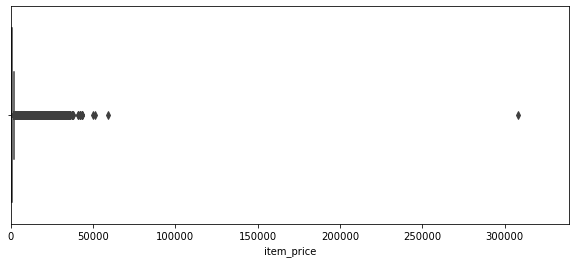

In [3]:
####investigate price variance

plt.figure(figsize=(10,4))
plt.xlim(transactions.item_price.min(), transactions.item_price.max()*1.1)
    
    #print (transactions[transactions["item_id"] == i]["item_price"])
sns.boxplot(x=transactions.item_price)




In [4]:


#To see the values
transactions.item_price.value_counts().sort_index()


-1.0000            1
 0.0700            2
 0.0875            1
 0.0900            1
 0.1000         2932
                ... 
 42990.0000        4
 49782.0000        1
 50999.0000        1
 59200.0000        1
 307980.0000       1
Name: item_price, Length: 19993, dtype: int64

It pops up some interesting things:

1. The Ramind were sold for 522 people and it was all summed up in one line giving the price of 307980.

2. The item Shipping (EMS) has a long array of prices and amounts of sales, all from shop 12. However, in the test set, we need to predict this item with 41 other shops. In transaction, their single price ranges from 38 to 1930 a piece. This item seems to be wild card.

3. The item "Microsoft Xbox One 1TB  Limited Edition" occupies a few spots in the top price items.

In [5]:
###also there is one price of -1
transactions.item_price.min()

transactions[transactions.item_price == transactions.item_price.min()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


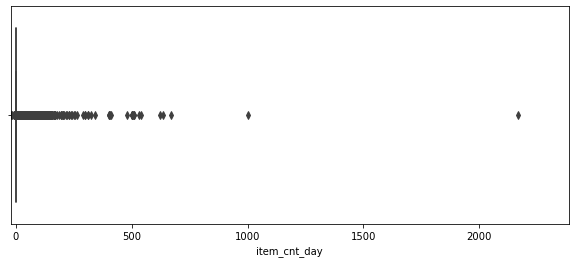

In [6]:
####investigate item_cnt_day variance

plt.figure(figsize=(10,4))
plt.xlim(transactions.item_cnt_day.min(), transactions.item_cnt_day.max()*1.1)
    
    #print (transactions[transactions["item_id"] == i]["item_price"])
sns.boxplot(x=transactions.item_cnt_day)



In [7]:
#To see the values
transactions.item_cnt_day.value_counts().sort_index()

-22.0      1
-16.0      1
-9.0       1
-6.0       2
-5.0       4
          ..
 624.0     1
 637.0     1
 669.0     1
 1000.0    1
 2169.0    1
Name: item_cnt_day, Length: 198, dtype: int64

According to https://www.kaggle.com/dlarionov/feature-engineering-xgboost, there are duplicate shops

In [8]:
shops[shops.shop_id == 57]

,shop_name,shop_id
57,"Якутск Орджоникидзе, 56",57


In [9]:
shops[shops.shop_id == 0]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


In [10]:
shops[shops.shop_id == 1]

,shop_name,shop_id
1,"!Якутск ТЦ ""Центральный"" фран",1


In [11]:
shops[shops.shop_id == 58]

,shop_name,shop_id
58,"Якутск ТЦ ""Центральный""",58


In [12]:
shops[shops.shop_id == 10]

,shop_name,shop_id
10,Жуковский ул. Чкалова 39м?,10


In [13]:
shops[shops.shop_id == 11]

,shop_name,shop_id
11,Жуковский ул. Чкалова 39м²,11


In [14]:
###fix the outliers

transactions = transactions[transactions.item_price< 80000]
transactions = transactions[transactions.item_cnt_day < 1001]

median = transactions[(transactions.shop_id==32)&(transactions.item_id==2973)&(transactions.date_block_num==4)&(transactions.item_price>0)].item_price.median()
transactions.loc[transactions.item_price<0, 'item_price'] = median


# Якутск Орджоникидзе, 56
transactions.loc[transactions.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
transactions.loc[transactions.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
transactions.loc[transactions.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [15]:
####Borrow the codes from Programming_assignment_week_3

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = transactions.loc[transactions['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = transactions.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}, 'item_price': {'item_price': "mean"}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
all_data["target"] = all_data["target"].clip(0,20)


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


In [16]:
all_data.head()

,shop_id,item_id,date_block_num,target,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


Do some trend visualization

Visualize some items in shop 34

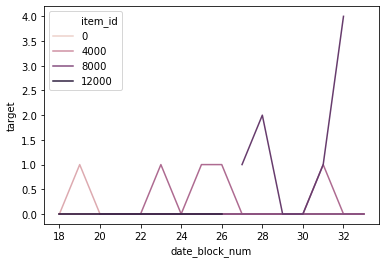

In [17]:
tmp = all_data.groupby(["shop_id", "date_block_num", "item_id"])["target"].sum().reset_index()

shop_34 = tmp[tmp["shop_id"] == 34]

random_item = shop_34['item_id'].sample(n=10, random_state=1).to_list()


shop_34_random_item = shop_34[shop_34["item_id"].isin(random_item)]

ax = sns.lineplot(x=shop_34_random_item["date_block_num"], y=shop_34_random_item["target"].clip(0, 20), hue=shop_34_random_item["item_id"])

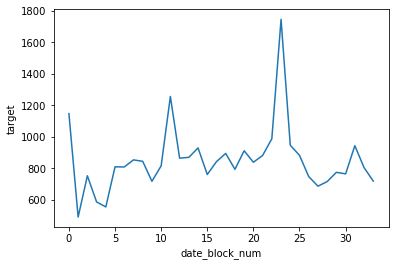

In [18]:
tmp = all_data.groupby(["shop_id", "date_block_num"])["target"].sum().reset_index()
#tmp
ax = sns.lineplot(x=tmp[tmp["shop_id"] == 2]["date_block_num"], y=tmp[tmp["shop_id"] == 2]["target"])

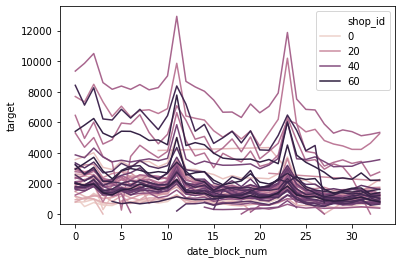

In [19]:
ax = sns.lineplot(x=tmp["date_block_num"], y=tmp["target"], hue=tmp["shop_id"])

So, there were some good time in the past, somewhere date_block_num 11 and 23. But the general trend is downwards for all the shops.

In [20]:
len(all_data)

10913804

In [21]:
all_data.head()

,shop_id,item_id,date_block_num,target,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


In [22]:
## check for data leak in test

test["item_id"].value_counts().to_frame("item_count")["item_count"].value_counts()

42    5100
Name: item_count, dtype: int64

In [23]:
test["shop_id"].value_counts()

59    5100
16    5100
28    5100
26    5100
25    5100
24    5100
22    5100
21    5100
19    5100
18    5100
15    5100
58    5100
14    5100
12    5100
11    5100
7     5100
6     5100
5     5100
4     5100
3     5100
31    5100
34    5100
35    5100
36    5100
57    5100
56    5100
55    5100
53    5100
52    5100
50    5100
49    5100
48    5100
47    5100
46    5100
45    5100
44    5100
42    5100
41    5100
39    5100
38    5100
37    5100
2     5100
Name: shop_id, dtype: int64

In [24]:
test = test.merge(items[["item_id", "item_category_id"]], on = ["item_id"], how="left")


In [25]:
test["item_category_id"].value_counts().to_frame("category_count")

,category_count
40,32340
55,28224
37,13902
31,11634
58,9366
...,...
11,42
79,42
71,42
74,42


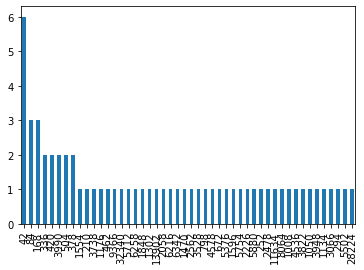

In [26]:
test["item_category_id"].value_counts().to_frame("category_count")["category_count"].value_counts().plot(kind='bar')

So there are 5100 items and all have been chosen 42 times and 42 shops and all have been chosen 5100 times. The categories are unevenly distributed, but it seems 42 is magic number too because 6 categories appear 42 tims and 3 categories 84 times and so on. However. 1. Time to investigate some leak? 2. It also implies that many shop-item combi may not exist in reality, that is, certain shops don't sell many of the items in the test set, result in a safe default values of 0.

In [27]:
###### target encoding several features, inspired by https://www.kaggle.com/szhou42/predict-future-sales-top-11-solution

print ("Doing target_shop")



target_encoding(all_data, ['shop_id', 'date_block_num'], "target", "target_shop", "sum")



print ("Doing target_item")

target_encoding(all_data, ['item_id', 'date_block_num'], "target", "target_item", "mean")



print ("Doing target_item_shop")

target_encoding(all_data, ['item_id', "shop_id", 'date_block_num'], "target", "target_item_shop", "sum")


print ("Doing price_target_item_shop")

target_encoding(all_data, ['item_id', "shop_id", 'date_block_num'], "item_price", "price_target_item_shop", "mean")


all_data = all_data.merge(items[["item_id", "item_category_id"]], on = ["item_id"], how="left")

print ("Doing target_category")

target_encoding(all_data, ['shop_id', 'item_category_id', 'date_block_num'], "target", "target_category_shop", "sum")


# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)

gc.collect();

Doing target_shop
Doing target_item
Doing target_item_shop
Doing price_target_item_shop
Doing target_category


In [28]:
#### combine train test, then do the time lag


test.sort_values("ID", inplace=True)

test["target"] =0
test["item_price"] =0
test["date_block_num"] = transactions["date_block_num"].max() + 1
test["target_shop"] = 0
test["target_item"] = 0
test["target_category_shop"] = 0
test["target_item_shop"] = 0

train_test_together = pd.concat([all_data, test])


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [29]:
### do some sanity check

train_test_together[(train_test_together["item_id"] == 2252) & (train_test_together["shop_id"] == 34)]

,ID,date_block_num,item_category_id,item_id,item_price,price_target_item_shop,shop_id,target,target_category_shop,target_item,target_item_shop,target_shop
6593072,NaN,18,30,2252,0.0,0.0,34,0.0,0.0,1.559570,0.0,2.0
6875754,NaN,19,30,2252,418.5,418.5,34,1.0,72.0,1.784180,1.0,368.0
7234019,NaN,20,30,2252,419.0,419.0,34,1.0,49.0,1.200195,1.0,400.0
7713926,NaN,21,30,2252,419.0,419.0,34,1.0,52.0,1.750000,1.0,317.0
7807836,NaN,22,30,2252,0.0,0.0,34,0.0,57.0,2.240234,0.0,431.0
8224828,NaN,23,30,2252,399.0,399.0,34,1.0,68.0,3.099609,1.0,638.0
8643886,NaN,24,30,2252,0.0,0.0,34,0.0,62.0,3.000000,0.0,473.0
8796007,NaN,25,30,2252,399.0,399.0,34,2.0,67.0,1.936523,2.0,388.0
9074624,NaN,26,30,2252,399.0,399.0,34,1.0,63.0,2.283203,1.0,430.0
9326831,NaN,27,30,2252,0.0,0.0,34,0.0,74.0,1.723633,0.0,370.0


In [30]:
## have a look at the size
len(train_test_together)

11128004

In [31]:
#####compute time lags

added_features = []

lag_period = list(range(1,7))

index_cols = ['item_id', "shop_id", 'date_block_num']

train_test_together, new_features = create_lag(train_test_together, index_cols, "date_block_num", "target_item_shop", 'sum', lag_period)

added_features += new_features



index_cols = ['item_id', 'date_block_num']

train_test_together, new_features = create_lag(train_test_together, index_cols, "date_block_num", "target_item", 'mean', lag_period)

added_features += new_features



index_cols = ['shop_id', 'date_block_num']

train_test_together, new_features = create_lag(train_test_together, index_cols, "date_block_num", "target_shop", 'sum', lag_period)

added_features += new_features



index_cols = ['shop_id', 'item_category_id', 'date_block_num']

train_test_together, new_features = create_lag(train_test_together, index_cols, "date_block_num", "target_category_shop", 'mean', lag_period)

added_features += new_features



index_cols = ['item_id', 'shop_id', 'date_block_num']

train_test_together, new_features = create_lag(train_test_together, index_cols, "date_block_num", "item_price", 'mean', lag_period)

added_features += new_features

/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:94: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [32]:
### sanity check

added_features

['target_item_shop_lag_1',
 'target_item_shop_lag_2',
 'target_item_shop_lag_3',
 'target_item_shop_lag_4',
 'target_item_shop_lag_5',
 'target_item_shop_lag_6',
 'target_item_lag_1',
 'target_item_lag_2',
 'target_item_lag_3',
 'target_item_lag_4',
 'target_item_lag_5',
 'target_item_lag_6',
 'target_shop_lag_1',
 'target_shop_lag_2',
 'target_shop_lag_3',
 'target_shop_lag_4',
 'target_shop_lag_5',
 'target_shop_lag_6',
 'target_category_shop_lag_1',
 'target_category_shop_lag_2',
 'target_category_shop_lag_3',
 'target_category_shop_lag_4',
 'target_category_shop_lag_5',
 'target_category_shop_lag_6',
 'item_price_lag_1',
 'item_price_lag_2',
 'item_price_lag_3',
 'item_price_lag_4',
 'item_price_lag_5',
 'item_price_lag_6']

In [33]:
train_test_together.to_csv("./kaggle/output/train_test_together.csv", index=False)

In [2]:
### load the data

train_test_together = pd.read_csv("./kaggle/output/train_test_together.csv")


In [3]:
added_features = ['target_item_shop_lag_1',
 'target_item_shop_lag_2',
 'target_item_shop_lag_3',
 'target_item_shop_lag_4',
 'target_item_shop_lag_5',
 'target_item_shop_lag_6',
 'target_item_lag_1',
 'target_item_lag_2',
 'target_item_lag_3',
 'target_item_lag_4',
 'target_item_lag_5',
 'target_item_lag_6',
 'target_shop_lag_1',
 'target_shop_lag_2',
 'target_shop_lag_3',
 'target_shop_lag_4',
 'target_shop_lag_5',
 'target_shop_lag_6',
 'target_category_shop_lag_1',
 'target_category_shop_lag_2',
 'target_category_shop_lag_3',
 'target_category_shop_lag_4',
 'target_category_shop_lag_5',
 'target_category_shop_lag_6',
 'item_price_lag_1',
 'item_price_lag_2',
 'item_price_lag_3',
 'item_price_lag_4',
 'item_price_lag_5',
 'item_price_lag_6']

In [34]:
### train the model with 6 ... 32, validate on 33, enable gpu
"""

best paras from gridsearchcv, codes are at the end of the notebook
{'max_depth': 10, 'min_child_weight': 500, 'subsample': 0.6, 'tree_method': 'gpu_hist'} 
with score -0.8415075370796499
"""


baseline_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num'] +  added_features + ['target']


train_time_range_lo = (train_test_together['date_block_num'] >= 6)
train_time_range_hi =  (train_test_together['date_block_num'] <= 32)


final_trainset = train_test_together[train_time_range_lo & train_time_range_hi]

train_x = final_trainset[baseline_features]
train_y = final_trainset["target"]
train_x.drop("target", axis=1, inplace=True)


val_time = (train_test_together['date_block_num'] == 33)

final_trainset = train_test_together[val_time]


val_x = final_trainset[baseline_features]
val_y = final_trainset["target"]
val_x.drop("target", axis=1, inplace=True)



#model = xgb.XGBRegressor(max_depth = 8, min_child_weight=300, subsample = 0.8, eta = 0.3, seed = 43, nthread = 16, tree_method="gpu_hist")
model = xgb.XGBRegressor(max_depth = 10, min_child_weight=500, subsample = 0.6, eta = 0.3, tree_method="gpu_hist")


#model.fit(train_x, train_y)
model.fit(
    train_x, train_y, early_stopping_rounds = 10,
    eval_metric="rmse", 
    eval_set=[(train_x, train_y), (val_x, val_y)]

    )


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:29:52] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.1867	validation_1-rmse:1.12125
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.14123	validation_1-rmse:1.0877
[2]	validation_0-rmse:1.10268	validation_1-rmse:1.06008
[3]	validation_0-rmse:1.06875	validation_1-rmse:1.03443
[4]	validation_0-rmse:1.04077	validation_1-rmse:1.01508
[5]	validation_0-rmse:1.01732	validation_1-rmse:0.999514
[6]	validation_0-rmse:0.9976	validation_1-rmse:0.985972
[7]	validation_0-rmse:0.980397	validation_1-rmse:0.973514
[8]	validation_0-rmse:0.966258	validation_1-rmse:0.964578
[9]	validation_0-rmse:0.954439	validation_1-rmse:0.957027
[10]	validation_0-rmse:0.944345	validation_1-rmse:0.95098
[11]	validation_0-rmse:0.935355	validation_1-rmse:0.94

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=500, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, tree_method='gpu_hist', verbosity=1)

In [35]:
with open(r"./xgboost_gpu_best_para.m", "wb") as output_file:
    #cPickle.dump(d, output_file)

    pickle.dump(model, output_file)

In [36]:
#### predict 34, get 10/10 from coursera

test_time =  (train_test_together['date_block_num'] == 34)

testset = train_test_together[test_time]


test_x = testset[baseline_features]
#train_x = cv_trainset[baseline_features]
test_x.drop("target", axis=1, inplace=True)


preds = model.predict(test_x).clip(0, 20)

df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df.index.name='ID'


df.to_csv('xgboost_gpu_my_preds_with_best_para.csv')

In [25]:
### GridSearchCV, run separately, use only subset of the data to cv, get the best paras for xgboost,

baseline_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num'] +  added_features + ['target']


train_time_range_lo = (train_test_together['date_block_num'] >= 20)
train_time_range_hi =  (train_test_together['date_block_num'] <= 33)

final_trainset = train_test_together[train_time_range_lo & train_time_range_hi]


group_kfold = GroupKFold(n_splits=5)

groups = final_trainset['date_block_num']

X = final_trainset[baseline_features].copy()
y = final_trainset["target"].copy()
X.drop("target", axis=1, inplace=True)

_grid_cv =[]

for train_index, test_index in group_kfold.split(X, y, groups):
    _grid_cv.append((train_index, test_index))

    
xgb_parameters = {'subsample': [0.6, 0.8], "max_depth": [6, 8, 10], "min_child_weight": [100, 300, 500], "tree_method": ["gpu_hist"]}

model = xgb.XGBRegressor()

rmse_score = make_scorer(rmse, greater_is_better = False)


gs = GridSearchCV(model, xgb_parameters, scoring='neg_mean_squared_error', cv = _grid_cv)
gs.fit(train_x, train_y)

print(gs.best_params_, "with score", gs.best_score_)


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:40:17] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:40:25] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:40:32] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:40:40] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:40:48] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:40:56] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:41:04] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:41:13] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:41:21] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:41:28] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:41:35] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:41:42] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:41:50] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:41:57] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:42:05] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:42:13] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:42:20] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:42:27] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:42:35] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:42:42] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:42:50] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:42:58] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:43:05] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:43:12] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:43:20] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:43:27] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:43:35] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:43:42] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:43:49] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:43:57] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:44:04] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:44:12] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:44:21] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:44:30] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:44:39] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:44:48] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:44:56] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:45:04] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:45:14] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:45:23] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:45:32] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:45:41] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:45:50] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:45:59] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:46:08] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:46:16] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:46:25] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:46:33] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:46:41] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:46:50] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:46:58] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:47:06] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:47:14] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:47:22] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:47:30] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:47:38] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:47:47] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:47:54] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:48:03] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:48:11] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:48:19] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:48:29] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:48:38] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:48:48] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:48:58] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:49:08] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:49:18] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:49:28] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:49:38] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:49:48] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:49:58] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:50:07] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:50:16] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:50:25] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:50:34] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:50:44] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:50:53] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:51:03] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:51:12] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:51:21] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:51:31] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:51:40] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:51:49] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:51:58] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:52:07] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:52:16] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:52:25] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:52:34] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:52:44] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:52:53] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:53:02] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 10, 'min_child_weight': 500, 'subsample': 0.6, 'tree_method': 'gpu_hist'} with score -0.8415075370796499


catboost, a failed attempt, only 1.070510 in public LB

In [5]:
### train the model with 6 ... 32, validate on 33, enable gpu



baseline_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num'] +  added_features + ['target']


train_time_range_lo = (train_test_together['date_block_num'] >= 6)
train_time_range_hi =  (train_test_together['date_block_num'] <= 32)


final_trainset = train_test_together[train_time_range_lo & train_time_range_hi]

train_x = final_trainset[baseline_features]
train_y = final_trainset["target"]
train_x.drop("target", axis=1, inplace=True)


val_time = (train_test_together['date_block_num'] == 33)

final_trainset = train_test_together[val_time]


val_x = final_trainset[baseline_features]
val_y = final_trainset["target"]
val_x.drop("target", axis=1, inplace=True)



#model = xgb.XGBRegressor(max_depth = 8, min_child_weight=300, subsample = 0.8, eta = 0.3, seed = 43, nthread = 16, tree_method="gpu_hist")
model = CatBoostRegressor(bootstrap_type="Bernoulli", max_depth = 8, subsample = 0.8, eta = 0.3, eval_metric = 'RMSE', task_type="GPU",)


#model.fit(train_x, train_y)
model.fit(
    train_x, train_y, early_stopping_rounds = 10,
    #eval_metric="rmse", 
    #eval_set=[(train_x, train_y), (val_x, val_y)],
    eval_set=(val_x, val_y),
    use_best_model = True,
    cat_features = ['shop_id', 'item_id', 'item_category_id']

    )


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0:	learn: 1.0648196	test: 1.0712486	best: 1.0712486 (0)	total: 1.88s	remaining: 31m 13s
1:	learn: 0.9743031	test: 1.0412185	best: 1.0412185 (1)	total: 3.61s	remaining: 30m 3s
2:	learn: 0.9100514	test: 1.0308648	best: 1.0308648 (2)	total: 5.39s	remaining: 29m 50s
3:	learn: 0.8649944	test: 1.0357954	best: 1.0308648 (2)	total: 7.22s	remaining: 29m 57s
4:	learn: 0.8386426	test: 1.0408307	best: 1.0308648 (2)	total: 9.05s	remaining: 30m 1s
5:	learn: 0.8222604	test: 1.0392334	best: 1.0308648 (2)	total: 11.2s	remaining: 30m 56s
6:	learn: 0.8113003	test: 1.0392960	best: 1.0308648 (2)	total: 12.7s	remaining: 30m 7s
7:	learn: 0.8004221	test: 1.0372094	best: 1.0308648 (2)	total: 14.5s	remaining: 29m 56s
8:	learn: 0.7925702	test: 1.0331744	best: 1.0308648 (2)	total: 16.1s	remaining: 29m 30s
9:	learn: 0.7874512	test: 1.0299050	best: 1.0299050 (9)	total: 18.2s	remaining: 29m 58s
10:	learn: 0.7827014	test: 1.0301690	best: 1.0299050 (9)	total: 19.9s	remaining: 29m 47s
11:	learn: 0.7793931	test: 1.02858

In [6]:
test_time =  (train_test_together['date_block_num'] == 34)

testset = train_test_together[test_time]


test_x = testset[baseline_features]
#train_x = cv_trainset[baseline_features]
test_x.drop("target", axis=1, inplace=True)


preds = model.predict(test_x).clip(0, 20)

df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df.index.name='ID'


df.to_csv('catboost_gpu_my_preds.csv')

/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Stacking, didn't work, only 1.191728

In [4]:
### construct train_1

baseline_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num'] +  added_features + ['target']


train_time_range_lo = (train_test_together['date_block_num'] >= 6)
train_time_range_hi =  (train_test_together['date_block_num'] <= 31)


final_trainset = train_test_together[train_time_range_lo & train_time_range_hi]

train_x = final_trainset[baseline_features]
train_y = final_trainset["target"]
train_x.drop("target", axis=1, inplace=True)


val_time = (train_test_together['date_block_num'] == 32)

final_trainset = train_test_together[val_time]


val_x = final_trainset[baseline_features]
val_y = final_trainset["target"]
val_x.drop("target", axis=1, inplace=True)




test_time = (train_test_together['date_block_num'] == 33)

final_trainset = train_test_together[test_time]


test_x = final_trainset[baseline_features]
test_y = final_trainset["target"]
test_x.drop("target", axis=1, inplace=True)

/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
"""

best paras from gridsearchcv, codes are at the end of the notebook
{'max_depth': 10, 'min_child_weight': 500, 'subsample': 0.6, 'tree_method': 'gpu_hist'} 
with score -0.8415075370796499
"""


#model = xgb.XGBRegressor(max_depth = 8, min_child_weight=300, subsample = 0.8, eta = 0.3, seed = 43, nthread = 16, tree_method="gpu_hist")
model_xgb = xgb.XGBRegressor(max_depth = 10, min_child_weight=500, subsample = 0.6, eta = 0.3, tree_method="gpu_hist")


#model.fit(train_x, train_y)
model_xgb.fit(
    train_x, train_y, early_stopping_rounds = 10,
    eval_metric="rmse", 
    eval_set=[(train_x, train_y), (val_x, val_y)]

    )

with open(r"./xgboost_for_stacking.m", "wb") as output_file:
    #cPickle.dump(d, output_file)

    pickle.dump(model_xgb, output_file)
    
#### predict 34


preds = model_xgb.predict(test_x).clip(0, 20)

df_xgb = pd.DataFrame(preds, columns = ['item_cnt_month'])
df_xgb.index.name='ID'


df_xgb.to_csv('xgboost_for_stacking.csv')

/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[12:40:13] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.18812	validation_1-rmse:1.13406
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.14237	validation_1-rmse:1.09739
[2]	validation_0-rmse:1.10358	validation_1-rmse:1.0657
[3]	validation_0-rmse:1.06967	validation_1-rmse:1.03722
[4]	validation_0-rmse:1.04112	validation_1-rmse:1.0138
[5]	validation_0-rmse:1.0175	validation_1-rmse:0.994013
[6]	validation_0-rmse:0.997803	validation_1-rmse:0.978144
[7]	validation_0-rmse:0.980733	validation_1-rmse:0.964325
[8]	validation_0-rmse:0.966012	validation_1-rmse:0.951743
[9]	validation_0-rmse:0.953709	validation_1-rmse:0.941424
[10]	validation_0-rmse:0.943907	validation_1-rmse:0.933691
[11]	validation_0-rmse:0.935348	validation_1-rmse:0.

In [6]:
### linear regression

model_lr = LinearRegression()


#model.fit(train_x, train_y)
model_lr.fit(train_x.values, train_y)


#### predict 34
with open(r"./lr_for_stacking.m", "wb") as output_file:
    #cPickle.dump(d, output_file)

    pickle.dump(model_lr, output_file)



preds = model_lr.predict(test_x).clip(0, 20)

df_lr = pd.DataFrame(preds, columns = ['item_cnt_month'])
df_lr.index.name='ID'


df_lr.to_csv('lr_for_stacking.csv')

In [7]:
df_xgb.rename(columns = {"item_cnt_month": "xgb"}, inplace = True)
df_lr.rename(columns = {"item_cnt_month": "lr"}, inplace = True)
df_level_2 = df_lr.join(df_xgb)

In [8]:
stacker = LogisticRegression().fit(df_level_2, test_y)

/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [9]:
test_time = (train_test_together['date_block_num'] == 34)

final_trainset = train_test_together[test_time]


test_x = final_trainset[baseline_features]
test_y = final_trainset["target"]
test_x.drop("target", axis=1, inplace=True)



preds = model_xgb.predict(test_x).clip(0, 20)

df_xgb = pd.DataFrame(preds, columns = ['item_cnt_month'])
df_xgb.index.name='ID'


preds = model_lr.predict(test_x).clip(0, 20)

df_lr = pd.DataFrame(preds, columns = ['item_cnt_month'])
df_lr.index.name='ID'

df_xgb.rename(columns = {"item_cnt_month": "xgb"}, inplace = True)
df_lr.rename(columns = {"item_cnt_month": "lr"}, inplace = True)

df_level_2 = df_lr.join(df_xgb)
#df_xgb.to_csv('xgboost_for_stacking.csv')


preds = stacker.predict(df_level_2).clip(0, 20)

df_stacker = pd.DataFrame(preds, columns = ['item_cnt_month'])
df_stacker.index.name='ID'


df_stacker.to_csv('stacking_out.csv')


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
